In [5]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# Load data
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

# Standard train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print('Data ready:', X.shape, 'labels:', np.unique(y))


Data ready: (150, 4) labels: [0 1 2]


## Q7. Decision Tree (sklearn)
Train trees with `max_depth = 1, 2, 3`. Report training and test accuracies.

In [6]:

depths = [1, 2, 3]
results = []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    y_pred_train = dt.predict(X_train)
    y_pred_test = dt.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    results.append((d, train_acc, test_acc))

print("Depth | Train Acc | Test Acc")
for d, tr, te in results:
    print(f"{d:5d} | {tr:9.4f} | {te:8.4f}")

print("\nUnderfitting vs Overfitting:")
print("- Underfitting: low train & test accuracy (e.g., depth=1).")
print("- Overfitting: train >> test accuracy gap grows with capacity.")


Depth | Train Acc | Test Acc
    1 |    0.6667 |   0.6667
    2 |    0.9714 |   0.8889
    3 |    0.9810 |   0.9778

Underfitting vs Overfitting:
- Underfitting: low train & test accuracy (e.g., depth=1).
- Overfitting: train >> test accuracy gap grows with capacity.


## Q8. kNN Classification (2 features)
Use only **sepal length** and **sepal width**. Train for k = 1, 3, 5, 10 and plot decision boundaries.

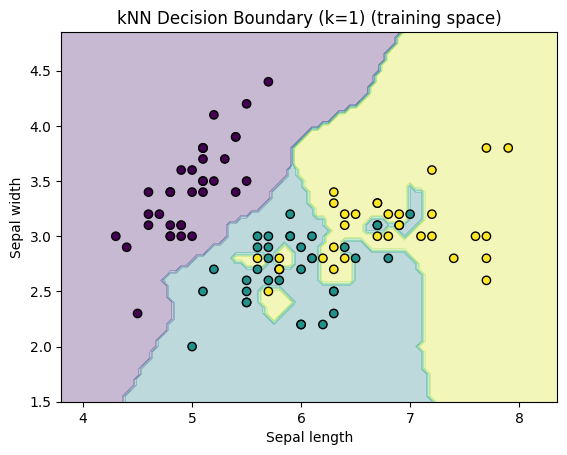

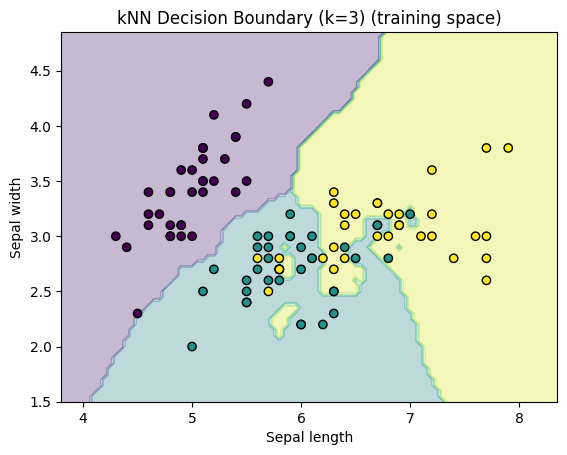

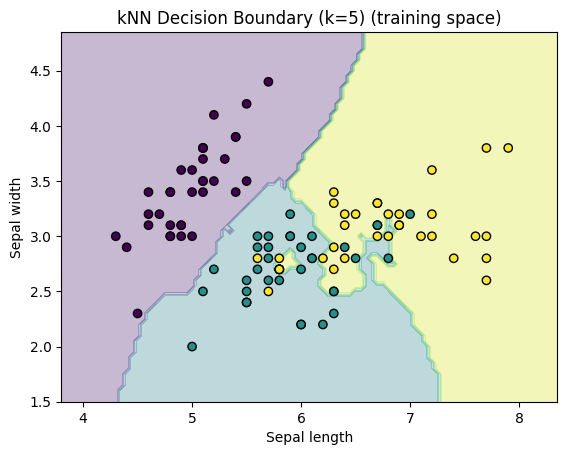

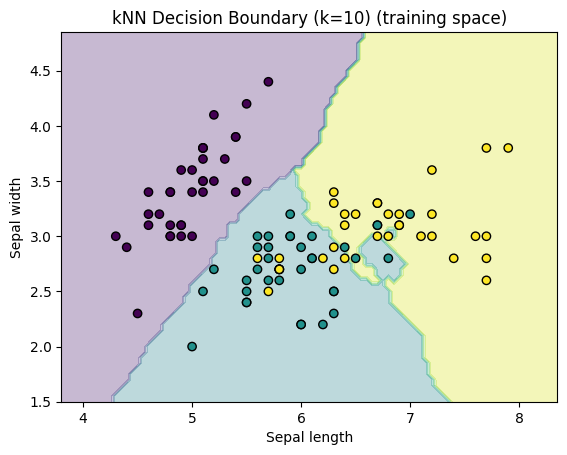

Saved boundary images: ['knn_boundary_k1.png', 'knn_boundary_k3.png', 'knn_boundary_k5.png', 'knn_boundary_k10.png']
As k increases, boundaries smooth (higher bias, lower variance). k=1 is jagged; k=10 smoother.


In [7]:

# Use only features 0 (sepal length) and 1 (sepal width)
X2 = X[:, :2]
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.30, random_state=42, stratify=y
)

def plot_decision_boundary_knn(k, X_train, y_train, title_suffix):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Meshgrid in feature space
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot (own figure; no explicit colors)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k')
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.title(f"kNN Decision Boundary (k={k}) {title_suffix}")
    out_path = f"knn_boundary_k{k}.png"
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    return out_path

saved_paths = []
for k in [1, 3, 5, 10]:
    p = plot_decision_boundary_knn(k, X2_train, y2_train, "(training space)")
    saved_paths.append(p)

print("Saved boundary images:", saved_paths)
print("As k increases, boundaries smooth (higher bias, lower variance). k=1 is jagged; k=10 smoother.")


## Q9. Performance Evaluation (kNN, k=5)
Compute confusion matrix, accuracy/precision/recall/F1 via `classification_report`, and macro-average ROC/AUC.

Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



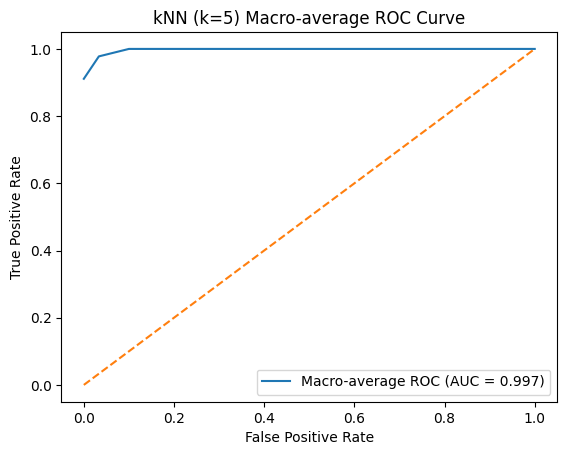

Macro-average AUC: 0.9974
ROC curve image saved: knn_k5_macro_roc.png


In [8]:

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
y_pred = knn5.predict(X_test)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# ROC & AUC (One-vs-Rest, macro-average)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = knn5.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("kNN (k=5) Macro-average ROC Curve")
roc_path = "knn_k5_macro_roc.png"
plt.legend(loc="lower right")
plt.savefig(roc_path, bbox_inches="tight")
plt.show()

print(f"Macro-average AUC: {macro_auc:.4f}")
print("ROC curve image saved:", roc_path)
